# Agent based SIR modelling in Haskell



An agent-based model (ABM) is a computational model which uses a bottom-up approach to simulate the actions and interactions of the system's constituent units (agents) to capture the global system behaviour. The autonomous agents are assigned characteristics (e.g. age) and follow various rules to ensure viable system dynamics. Spatiality can also be added to simulations.

Traditionally, ABM simulations are implemented as object-oriented programs due to the intuitive mapping of objects to agents. However, Functional Reactive Programming can also be used to guarantee the reproducibility of the simulation at compile time and avoid specific run-time bugs - which cannot be achieved in traditional object-oriented languages such as C#.


## What is Functional Reactive Programming?

In pure functional programming there are no side effects – which are often required for applications such as user-interaction or ABM. As a result, functional reactive programming (FRP) is used as it provides a way to implement systems with continuous and discrete time-semantics in pure functional languages.

In this case, FRP is implemented using an arrowised FRP approach. The central concept of the arrowised FRP is the Signal Function (SF). The SF represents a process overtime which maps an input signal to an output signal. A signal is a value which varies overtime. Thus, signifying that SFs have an awareness of the passing of time through the timestep of the system. This concept is essential for ABM due to actions of agents or events in simulation being time dependent.


## SIR model using Functional Reactive Programming

The goal is to use a Functional Reactive Programming (FRP) approach in Haskell to simulate a SIR (Susceptible, Infected, Recovered) model - which is a simple compartmental model. The general trend within such a SIR model is as below:
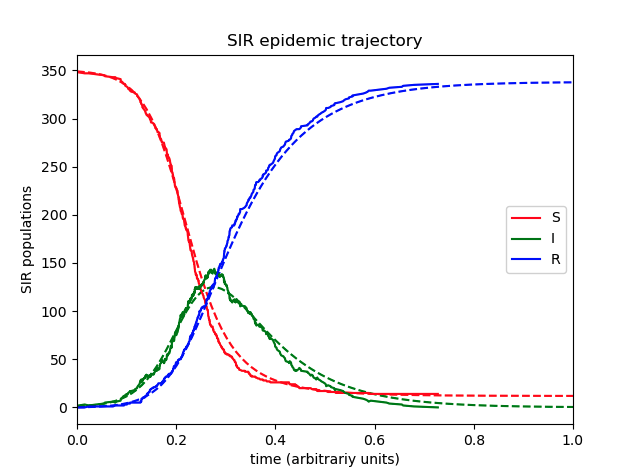

The following sections describe the approach taken to achieve the above trend using a FRP approach in Haskell.

## Setting up SIR simulation using Haskell

#### Language Extensions
Language extensions are used to enable certain features in Haskell. In this case, we require the following features:
- Arrows : to support the arrow notations
- Strict : to allows functions parameters to be evaluated before calls
- FlexibleContexts : to allow any types inside a typeClass

In [ ]:
-- Language Extensions
{-# LANGUAGE Arrows #-}
{-# LANGUAGE Strict #-}
{-# LANGUAGE FlexibleContexts #-}
--{-# LANGUAGE OverloadedStrings #-}

#### Loading Modules
Various modules required for the different aspect of simulation must be loaded.

In [ ]:
--module Main where
-- importing modules required for the simulation
import           Data.IORef
import           System.IO
import           Text.Printf

import           Control.Monad.Random
import           Control.Monad.Reader
import           Control.Monad.Trans.MSF.Random
import           Data.Array.IArray
import           FRP.BearRiver
import qualified Graphics.Gloss as GLO
import qualified Graphics.Gloss.Interface.IO.Animate as GLOAnim
import           Data.MonadicStreamFunction.InternalCore
--import Prelude hiding (filter, lookup, repeat)
--import qualified Graphics.Vega.VegaLite as VL
--import Graphics.Vega.VegaLite

#### SIR States as a Algebraic Data type
The main governing property of the agents within the SIR simulation is their state - which can be either Susceptible, Infected or Recovered. Here, these possible states are described as a Algebraic data type (ADT) to ensure ease of assignment later.

Additionally, a deriving (Show, Eq) clause is used to ensure the complier automatically generates instances of the Eq and Show classes for the ADT.

In [ ]:
-- Define the SIR states as ADT 
data SIRState = Susceptible | Infected | Recovered deriving (Show, Eq)

#### Define 2D environment
In this model, a A x A grid is used to define the spatial aspect of the model. Here, the discrete 2D environment is defined with a tuple.

In [ ]:
-- define a discrete 2D enviroment with a tuple 
type Disc2dCoord  = (Int, Int)

#### Define types to store agent's environment
During the simulation, the location and state of each agent must be retrievable. Hence, the type SIREnv is defined to allow agents to store their location coordinate and their state in an array.

In [ ]:
-- Array to store agent location and state
type SIREnv       = Array Disc2dCoord SIRState

Next, a type SIRMonad is defined to prevent the use of excessive RandomGen arguments. 

In [ ]:
type SIRMonad g   = Rand g 

#### Define the SIR Agent
SIRAgent is used to define Agents as Signal functions which receives the SIR states of all agents as input and outputs the current SIR state of the agent. It also returns the output in a SIRMonad context - which is building the monad over a rand monad.

In [ ]:
-- returns the output in a SIRMonad context
type SIRAgent g   = SF (SIRMonad g) SIREnv SIRState

SimSF type is similar to SIRagent above, however it does not receive any inputs and just outputs the current location and state of the agent. This is useful in instances where states of neighbours must be accessed by an agent to determine whether infection occurs. 


In [ ]:
-- outputs the environment of the SIR simulation
type SimSF g = SF (SIRMonad g) () SIREnv

#### Defining simulation context
A simulation context data struct which contains the various parameters (e.g. simulation time) is defined in terms of their type. The ! is used to specific it is a strictness declaration.

In [ ]:
-- data for the simulation (context data struct)
data SimCtx g = SimCtx 
  { simSf    :: !(SimSF g)
  , simEnv   :: !SIREnv
  , simRng   :: g
  , simSteps :: !Integer
  , simTime  :: !Time
  }

### Simulation Rules
In this simulation, the rules are:
- There is a population of size N in which all agents are either Susceptible, Infected or Recovered at a particular time.
- Initially, there is at least one infected person in the population.
- People interact with each other on average with a given rate of β per time-unit.
- People become infected with a given probability γ when interacting with an infected person.
- When infected, a person recovers on average after δ time-units.
- An infected person is immune to further infections (no reinfection).
- The 2D environment has either Moore or von Neumann neighbourhood.
- Agents are either static or can move freely around the cells.
- The cells allow either single or multiple occupants.
- Agents can read the states of all their neighbours which tells them if a neighbour is infected or not.

#### Simulation Parameters set up
To enforce the simulation rules, various simulation parameters are defined.

In [ ]:
-- contact rate or β 
contactRate :: Double
contactRate = 5.0

-- Infection rate or γ
infectivity :: Double
infectivity = 0.05

-- Recovery rate or δ
illnessDuration :: Double
illnessDuration = 15.0

-- 2D grid size
agentGridSize :: (Int, Int)
agentGridSize = (51, 51)

The outputs of the simulation will be a MATLAB file and an animation, hence parameters relevant to these are set.

In [ ]:
-- window size for animation 
winSize :: (Int, Int)
winSize = (800, 800)

-- window title for animation
winTitle :: String
winTitle = "Agent-Based SIR on 2D Grid"

#### Defining helper functions for the simulation

To ensure ease of understanding and seperation of functionality, various helper functions are defined for the different aspects of simulation (e.g. for generating the animation).

##### Functions related to the simulation context

mkSimCtx and runStepCtx are used to initalise the simulation context and update the simulation context respectively.

In [ ]:
-- Makes the simulation context (a specific data type) via various input parameters
mkSimCtx :: RandomGen g
         => SimSF g
         -> SIREnv
         -> g
         -> Integer
         -> Time
         -> SimCtx g
-- creating the specific SimCtx data struct to return
mkSimCtx sf env g steps t = SimCtx {
    simSf    = sf
  , simEnv   = env
  , simRng   = g
  , simSteps = steps
  , simTime  = t
  }

-- Runs the simulation context (???)
runStepCtx :: RandomGen g
           => DTime
           -> SimCtx g
           -> SimCtx g
runStepCtx dt ctx = ctx'
  where
    g   = simRng ctx
    sf  = simSf ctx

    sfReader            = unMSF sf ()
    sfRand              = runReaderT sfReader dt
    ((env, simSf'), g') = runRand sfRand g

    steps = simSteps ctx + 1
    t     = simTime ctx + dt
    ctx'  = mkSimCtx simSf' env g' steps t

##### Functions related to Boundary Conditions

Either Neumann or Moore boundary conditions (BC) are used within simulation. The areas surveyed in these is as represented in the following diagram:
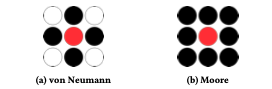


The following code is related to enforcing these BC:

In [ ]:
-- Neumann BC
neumann :: [Disc2dCoord]
neumann = [ topDelta, leftDelta, rightDelta, bottomDelta ]

-- Moore BC
moore :: [Disc2dCoord]
moore = [ topLeftDelta,    topDelta,     topRightDelta,
          leftDelta,                     rightDelta,
          bottomLeftDelta, bottomDelta,  bottomRightDelta ]

-- different Delta values for the BC
topLeftDelta :: Disc2dCoord
topLeftDelta      = (-1, -1)
topDelta :: Disc2dCoord
topDelta          = ( 0, -1)
topRightDelta :: Disc2dCoord
topRightDelta     = ( 1, -1)
leftDelta :: Disc2dCoord
leftDelta         = (-1,  0)
rightDelta :: Disc2dCoord
rightDelta        = ( 1,  0)
bottomLeftDelta :: Disc2dCoord
bottomLeftDelta   = (-1,  1)
bottomDelta :: Disc2dCoord
bottomDelta       = ( 0,  1)
bottomRightDelta :: Disc2dCoord
bottomRightDelta  = ( 1,  1)

##### Functions related to using RNG elements

drawRandomElemS and randomBoolM are related to use of RNG elements in simulation. A specific example is RandomBoolM being used to draw a random Boolean to determine whether an infection occurs in the susceptibleAgent function.

In [ ]:
-- allows to keep track of the changed random num generator internally
randomBoolM :: RandomGen g => Double -> Rand g Bool
randomBoolM p = getRandomR (0, 1) >>= (\r -> return $ r <= p)

-- similar to randomBool but takes input and returns a random elem from it
drawRandomElemS :: MonadRandom m => SF m [a] a
drawRandomElemS = proc as -> do
  r <- getRandomRS ((0, 1) :: (Double, Double)) -< ()
  let len = length as
  let idx = fromIntegral len * r
  let a =  as !! floor idx
  returnA -< a

##### Functions related to defining/governing agent behaviour

Aspects related to the behaviour of agents are defined via the various functions below.

initAgentsEnv initialises the simulation environment.

In [ ]:
-- initialises the simulation environment
initAgentsEnv :: (Int, Int) -> ([(Disc2dCoord, SIRState)], SIREnv)
initAgentsEnv (xd, yd) = (as, e)
  where
    xCenter = floor $ fromIntegral xd * (0.5 :: Double)
    yCenter = floor $ fromIntegral yd * (0.5 :: Double)
    -- populating the grid with susceptible agents everywhere except the centre
    sus = [ ((x, y), Susceptible) | x <- [0..xd-1], 
                                    y <- [0..yd-1],
                                    x /= xCenter ||
                                    y /= yCenter ] 
    -- populating the infected agent at the center                             
    inf = ((xCenter, yCenter), Infected)
    -- list of infected and susceptible agent locations
    as = inf : sus
    -- array of min and max grid size and the list of agent locations 
    e = array ((0, 0), (xd - 1, yd - 1)) as

In order to observe the general SIR trend, infection via observing the neighbours must be viable. The neighbours function takes the coordinates and returns the surround SIRstates. allNeighbours returns the state of all neighbours or agents.

In [ ]:
-- function not actually used
--neighbours :: SIREnv 
           -- -> Disc2dCoord 
           -- -> Disc2dCoord
           -- -> [Disc2dCoord] 
           -- -> [SIRState]
-- neighbours e (x, y) (dx, dy) n = map (e !) nCoords'
  -- where
    -- nCoords  = map (\(x', y') -> (x + x', y + y')) n
    -- nCoords' = filter (\(nx, ny) -> nx >= 0 && 
                                    -- ny >= 0 && 
                                    -- nx <= (dx - 1) &&
                                  -- ny <= (dy - 1)) nCoords
                                  
-- returns state of all neighbours or all agents 
allNeighbours :: SIREnv -> [SIRState]
allNeighbours = elems

Unlike the other states, the recovered state does not generate any event and rather just acts a sink which constantly returns Recovered.

In [ ]:
-- constant state is recovered 
recoveredAgent :: RandomGen g => SIRAgent g
recoveredAgent = arr (const Recovered) 

The function below describes the behaviour of an infected agent. This behaviour is governed by either recovering on average after delta time units or staying infected within a timestep.

In [ ]:
-- infected agent recovers on average after delta time units
-- infected agent ignores state of the other agents
infectedAgent :: RandomGen g => SIRAgent g
infectedAgent
    = switch
      -- delay the switching by 1 step, otherwise could
      -- make the transition from Susceptible to Recovered within time-step
      (infected >>> iPre (Infected, NoEvent))
      (const recoveredAgent)
  where
    infected :: RandomGen g => SF (SIRMonad g) SIREnv (SIRState, Event ())
    infected = proc _ -> do
      -- illness duration = infected agent
      recovered <- occasionally illnessDuration () -< ()
      if isEvent recovered
        -- otherwise recovered agent as the updated state
        then returnA -< (Recovered, Event ())
        else returnA -< (Infected, NoEvent)

susceptibleAgent describes the behaviour of a susceptible agent - which is governed by querying the surrounding neighbours and either getting infected based on the parameter γ (event generated) or staying susceptible (no event)

In [ ]:
-- behaviour of susceptible agent
susceptibleAgent :: RandomGen g => Disc2dCoord -> SIRAgent g
susceptibleAgent _coord
    = switch 
      -- delay the switching by 1 step, otherwise could
      -- make the transition from Susceptible to Recovered within time-step
      (susceptible >>> iPre (Susceptible, NoEvent))
      (const infectedAgent)
  where
    susceptible :: RandomGen g 
                => SF (SIRMonad g) SIREnv (SIRState, Event ())
    susceptible = proc env -> do
      -- use occasionally to make contact on average 
      makeContact <- occasionally (1 / contactRate) () -< ()

      if not $ isEvent makeContact 
        then returnA -< (Susceptible, NoEvent)
        else (do
          -- take env, the dimensions of grid and neighbourhood info
          --let ns = neighbours env coord agentGridSize moore
          -- queries the environemtn for its neighbours - in this case appears to be all neighbours 
          let ns = allNeighbours env
          s <- drawRandomElemS -< ns -- randomly selects one
          case s of
            Infected -> do
              infected <- arrM (const (lift $ randomBoolM infectivity)) -< ()
              -- upon infection,
              if infected 
                -- event returned which returns in switching into the infected agent SF (to behave as such)
                then returnA -< (Infected, Event ())
                else returnA -< (Susceptible, NoEvent)
            _       -> returnA -< (Susceptible, NoEvent))

sirAgent defines the behaviour of the agent depending on the initial state. Only the suspectible agent receives the coordinates as the infected and recovered agents do not require this information.

In [ ]:
-- defines agent behaviour based on their initial state
sirAgent :: RandomGen g => Disc2dCoord -> SIRState -> SIRAgent g
sirAgent coord Susceptible = susceptibleAgent coord
sirAgent _     Infected    = infectedAgent
sirAgent _     Recovered   = recoveredAgent -- recovered agent ignores gen bc they stay immune

The simulationStep function is a closed feedback loop which takes the current signal functions and returns the new agent states. 

In [ ]:
simulationStep :: RandomGen g
               => [(SIRAgent g, Disc2dCoord)]
               -> SIREnv
               -> SF (SIRMonad g) () SIREnv
simulationStep sfsCoords env = MSF $ \_ -> do
    let (sfs, coords) = unzip sfsCoords 

    -- run all agents sequentially but keep the environment
    -- read-only: it is shared as input with all agents
    -- and thus cannot be changed by the agents themselves
    -- run agents sequentially but with shared, read-only environment
    ret <- mapM (`unMSF` env) sfs
    -- construct new environment from all agent outputs for next step
    let (as, sfs') = unzip ret
        env' = foldr (\(coord, a) envAcc -> updateCell coord a envAcc) env (zip coords as)
        
        sfsCoords' = zip sfs' coords
        cont       = simulationStep sfsCoords' env'
    return (env', cont)
  where
    updateCell :: Disc2dCoord -> SIRState -> SIREnv -> SIREnv
    updateCell c s e = e // [(c, s)]

##### Functions related to collating simulation data

To generate the MATLAB script and animation, various functions that collate the data are required.

aggregateStates is used to collate the number of susceptible, infected and recovered agents within the simulation. This function is used both for the animation and the plot (later).

In [ ]:
-- get counts of states
aggregateStates :: [SIRState] -> (Double, Double, Double)
aggregateStates as = (susceptibleCount, infectedCount, recoveredCount)
  where
    susceptibleCount = fromIntegral $ length $ filter (Susceptible==) as
    infectedCount = fromIntegral $ length $ filter (Infected==) as
    recoveredCount = fromIntegral $ length $ filter (Recovered==) as

siraggregateStates collates the susceptibleCount, infectedCount, recoveredCount information as strings.

In [ ]:
-- get counts into strings
sirAggregateToString :: (Double, Double, Double) -> String
sirAggregateToString (susceptibleCount, infectedCount, recoveredCount) =
  printf "%f" susceptibleCount
  ++ "," ++ printf "%f" infectedCount
  ++ "," ++ printf "%f" recoveredCount
  ++ ";"

##### Functions related to generating the MATLAB output

Another output of this simulation is a MATLAB file which can be run to generate a graph of the SIR populations overtime. The functions writeAggregatesToFile, writeMatlabPlot and sirAggregateToString are related to generating the content of this file.

In [ ]:
-- Write simulation results into MATLAB file 
writeAggregatesToFile :: String 
                      -> DTime
                      -> [(Double, Double, Double)] 
                      -> IO ()
writeAggregatesToFile fileName dt dynamics = do
  fileHdl <- openFile fileName WriteMode
  hPutStrLn fileHdl "dynamics = ["
  mapM_ (hPutStrLn fileHdl . sirAggregateToString) dynamics
  hPutStrLn fileHdl "];"

  writeMatlabPlot fileHdl dt

  hClose fileHdl

-- Write contents of MATLAB file
writeMatlabPlot :: Handle 
                -> DTime
                -> IO ()
writeMatlabPlot fileHdl dt = do
  hPutStrLn fileHdl "susceptible = dynamics (:, 1);"
  hPutStrLn fileHdl "infected = dynamics (:, 2);"
  hPutStrLn fileHdl "recovered = dynamics (:, 3);"
  hPutStrLn fileHdl "totalPopulation = susceptible(1) + infected(1) + recovered(1);"

  hPutStrLn fileHdl "susceptibleRatio = susceptible ./ totalPopulation;"
  hPutStrLn fileHdl "infectedRatio = infected ./ totalPopulation;"
  hPutStrLn fileHdl "recoveredRatio = recovered ./ totalPopulation;"

  hPutStrLn fileHdl "steps = length (susceptible);"
  hPutStrLn fileHdl "indices = 0 : steps - 1;"
  hPutStrLn fileHdl $ "indices = indices ./ " ++ show (1 / dt) ++ ";"

  hPutStrLn fileHdl "figure"
  hPutStrLn fileHdl "plot (indices, susceptibleRatio.', 'color', 'blue', 'linewidth', 2);"
  hPutStrLn fileHdl "hold on"
  hPutStrLn fileHdl "plot (indices, infectedRatio.', 'color', 'red', 'linewidth', 2);"
  hPutStrLn fileHdl "hold on"
  hPutStrLn fileHdl "plot (indices, recoveredRatio.', 'color', 'green', 'linewidth', 2);"

  hPutStrLn fileHdl "set(gca,'YTick',0:0.05:1.0);"
  
  hPutStrLn fileHdl "xlabel ('Time');"
  hPutStrLn fileHdl "ylabel ('Population Ratio');"
  hPutStrLn fileHdl "legend('Susceptible','Infected', 'Recovered');"

-- get counts into strings
sirAggregateToString :: (Double, Double, Double) -> String
sirAggregateToString (susceptibleCount, infectedCount, recoveredCount) =
  printf "%f" susceptibleCount
  ++ "," ++ printf "%f" infectedCount
  ++ "," ++ printf "%f" recoveredCount
  ++ ";"

##### Functions for generating  MATLAB file

writeSimulationUntil uses the above auxilliary functions to generate the overall MATLAB file

In [ ]:
-- Function gets the states of S,I,R and write the results 
--to a MATLAB file
writeSimulationUntil :: RandomGen g
                     => Time
                     -> DTime
                     -> SimCtx g
                     -> String
                     -> IO ()
writeSimulationUntil tMax dt ctx0 fileName = do
    fileHdl <- openFile fileName WriteMode
    hPutStrLn fileHdl "dynamics = ["
    writeSimulationUntilAux 0 ctx0 fileHdl
    hPutStrLn fileHdl "];"

    writeMatlabPlot fileHdl dt 

    hClose fileHdl
  where
    writeSimulationUntilAux :: RandomGen g
                            => Time
                            -> SimCtx g
                            -> Handle
                            -> IO ()
    writeSimulationUntilAux t ctx fileHdl 
        | t >= tMax = return ()
        | otherwise = do
          let env  = simEnv ctx
              aggr = aggregateStates $ elems env
  
              t'   = t + dt
              ctx' = runStepCtx dt ctx

          hPutStrLn fileHdl (sirAggregateToString aggr)

          writeSimulationUntilAux t' ctx' fileHdl

##### Functions for generating the animation

visualiseSimulation generates and updates the animation.

In [ ]:
-- creates the animation output 
visualiseSimulation :: RandomGen g
                    => DTime
                    -> SimCtx g
                    -> IO ()
visualiseSimulation dt ctx0 = do
    ctxRef <- newIORef ctx0

    GLOAnim.animateIO
    
      (GLO.InWindow winTitle winSize (0, 0))
      GLO.white
      (nextFrame ctxRef)
      (const $ return ())

  where
    (cx, cy)   = agentGridSize
    (wx, wy)   = winSize
    cellWidth  = (fromIntegral wx / fromIntegral cx) :: Double
    cellHeight = (fromIntegral wy / fromIntegral cy) :: Double

    nextFrame :: RandomGen g
              => IORef (SimCtx g)
              -> Float 
              -> IO GLO.Picture
    nextFrame ctxRef _ = do
      ctx <- readIORef ctxRef
      
      let ctx' = runStepCtx dt ctx
      writeIORef ctxRef ctx'

      return $ ctxToPic ctx

    ctxToPic :: RandomGen g
             => SimCtx g 
             -> GLO.Picture
    ctxToPic ctx = GLO.Pictures $ aps ++ [timeStepTxt]
      where
          env = simEnv ctx
          as  = assocs env
          aps = map renderAgent as
          t   = simTime ctx

          (tcx, tcy)  = transformToWindow (-7, 10)
          timeTxt     = printf "%0.1f" t
          timeStepTxt = GLO.color GLO.black $ GLO.translate tcx tcy $ GLO.scale 0.5 0.5 $ GLO.Text timeTxt

    renderAgent :: (Disc2dCoord, SIRState) -> GLO.Picture
    renderAgent (coord, Susceptible) 
        = GLO.color (GLO.makeColor 0.0 0.0 0.7 1.0) $ GLO.translate x y $ GLO.Circle (realToFrac cellWidth / 2)
      where
        (x, y) = transformToWindow coord
    renderAgent (coord, Infected)    
        = GLO.color (GLO.makeColor 0.7 0.0 0.0 1.0) $ GLO.translate x y $ GLO.ThickCircle 0 (realToFrac cellWidth)
      where
        (x, y) = transformToWindow coord
    renderAgent (coord, Recovered)   
        = GLO.color (GLO.makeColor 0.0 0.70 0.0 1.0) $ GLO.translate x y $ GLO.ThickCircle 0 (realToFrac cellWidth)
      where
        (x, y) = transformToWindow coord

    transformToWindow :: Disc2dCoord -> (Float, Float)
    transformToWindow (x, y) = (x', y')
      where
        rw = cellWidth
        rh = cellHeight

        halfXSize = fromRational (toRational wx / 2.0)
        halfYSize = fromRational (toRational wy / 2.0)

        x' = fromRational (toRational (fromIntegral x * rw)) - halfXSize
        y' = fromRational (toRational (fromIntegral y * rh)) - halfYSize

##### Functions for running simulation

runSimulationUntil runs the overall simulation for the desired duration.

In [ ]:
-- Function that runs the simulation 
runSimulationUntil :: RandomGen g
                   => Time
                   -> DTime
                   -> SimCtx g
                   -> [(Double, Double, Double)]
-- With the max time, time step and initial context, run simulation via the Aux function
runSimulationUntil tMax dt ctx0 = runSimulationAux 0 ctx0 []
  where
    runSimulationAux :: RandomGen g
                      => Time
                      -> SimCtx g
                      -> [(Double, Double, Double)]
                      -> [(Double, Double, Double)]
    runSimulationAux t ctx acc 
        | t >= tMax = acc -- if time step is greater than tmax, 
        | otherwise = runSimulationAux t' ctx' acc'
      where
        env  = simEnv ctx -- 
        aggr = aggregateStates $ elems env

        t'   = t + dt -- increase time by timestep
        ctx' = runStepCtx dt ctx -- get new step context
        acc' = aggr : acc
        
        


## Main Function

The main function below sets up the general simulation via various steps and enables a method of getting output either through a animation or through a MATLAB file output.

In [ ]:
-- main function which governs the type of output from simulation.
main :: IO ()
main = do
  hSetBuffering stdout NoBuffering
  -- enabling the visualisation/animation 
  let visualise = True
      t         = 100 -- simulation duration 
      dt        = 0.1 -- time step of simulation 
      seed      = 123 -- seed for RNG -- 42 leads to recovery without any infection
      
      g         = mkStdGen seed -- takes the seed and creates the RNG
      (as, env) = initAgentsEnv agentGridSize -- initalises the environment based on grid size
      sfs       = map (\(coord, a) -> (sirAgent coord a, coord)) as -- mapping agents to coordinates
      sf        = simulationStep sfs env -- processsing the simualtion with agents and environment
      ctx       = mkSimCtx sf env g 0 0 -- creates the simulation context via various inputs 

-- if animation is enabled
  if visualise
  -- then create the animation window and update it
    then visualiseSimulation dt ctx
    else do
    -- else write the results into a MATLAB file
      --let ret = runSimulationUntil t dt ctx
      --writeAggregatesToFile "SIR_DUNAI.m" ret 
      writeSimulationUntil t dt ctx "SIR_DUNAI_dt001.m"-- we will change to a chart in haskell or csv 



# Results -- **csv file read into list not working yet*

To be finalised with charts.

In [ ]:
{-# LANGUAGE ScopedTypeVariables #-}

import qualified Data.ByteString.Lazy as BL
import Data.Csv
import qualified Data.Vector as V

-- commented out code is the code I tried 
-- let SIRNumbers = []

-- merge :: [a] -> [a] -> [a]
-- merge xs     []     = xs
-- merge []     ys     = ys
-- merge (x:xs) (y:ys) = x : y : merge xs ys


printResults :: IO ()
printResults = do
    csvData <- BL.readFile "myFile.csv"
    case decode NoHeader csvData of
        Left err -> putStrLn err
        Right v -> V.forM_ v $ \ (susceptible :: Int,infected :: Int, recovered :: Int) ->
            -- want to save the columns of the csv file as lists so it can be plotted
            -- code I tried 
            -- SIRNumbers = merge SIRNumbers [susceptible, infected, recovered]
            
            -- printing results - works fine (so read is successful)
            putStrLn $  show susceptible ++ " S " ++ show infected ++ " I" 
   
printResults

2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2600 S 1 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2599 S 2 I
2598 S 3 I
2598 S 3 I
2598 S 3 I
2598 S 3 I
2598 S 3 I
2598 S 3 I
2598 S 3 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2597 S 4 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2596 S 5 I
2595 S 6 I
2595 S 6 I
2595 S 6 I
2595 S 6 I
2595 S 6 I
2595 S 6 I
2594 S 7 I
2594 S 7 I
2594 S 7 I
2594 S 7 I
2594 S 7 I
2594 S 7 I
2594 S 7 I
2593 S 8 I
2592 S 9 I
2592 S 9 I
2592 S 9 I
2592 S 9 I
2592 S 9 I
2592 S 9 I
2591 S 10 I
2591 S 10 I
2591 S 10 I
2591 S 10 I
2590 S 11 I
2590 S 11 I
2590 S 11 I
2590 S 11 I
2590 S 11 I
2589 S 12 I
2589 S 12 I
2589 S 12 I
2589 S 12

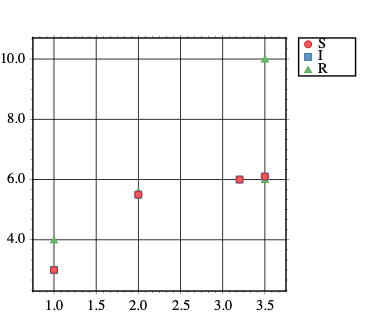

In [10]:
import Plots.Axis  (Axis, r2Axis)
import Plots.Axis.ColourBar (colourBar)
import Plots.Axis.Render (renderAxis, r2AxisMain)
import Plots.Axis.Scale (axisExtend, noExtend)
import Plots.Style (axisColourMap, magma, greys)
import Plots.Types (display)
import Plots.Types.HeatMap

import Control.Lens ((&~), (.=))
import Diagrams.Backend.Cairo (B, Cairo)
import Diagrams.TwoD.Types (V2)
import Diagrams.Core.Types (QDiagram)
import IHaskell.Display.Diagrams
import IHaskell.Display.Juicypixels hiding (display)
import Plots

mydata1 = [(1,3), (2,5.5), (3.2, 6), (3.5, 6.1)]
mydata2 = [(1,3), (2,5.5), (3.2, 6), (3.5, 6.1)]
mydata3 = [(1,4), (2,5.6), (3.5, 6), (3.5, 10)]
--
scatterAxis :: Axis B V2 Double
scatterAxis = r2Axis &~ do
    scatterPlot mydata1 $ key "S"
    scatterPlot mydata2 $ key "I"
    scatterPlot mydata3 $ key "R"
--
scatterExample = renderAxis scatterAxis
diagram scatterExample